In [8]:
import rasterio 
import rasterio.plot
from rasterio.plot import show
import pandas as pd
import matplotlib.pyplot as plt

## 1. Ouverture du fichier + visualisation

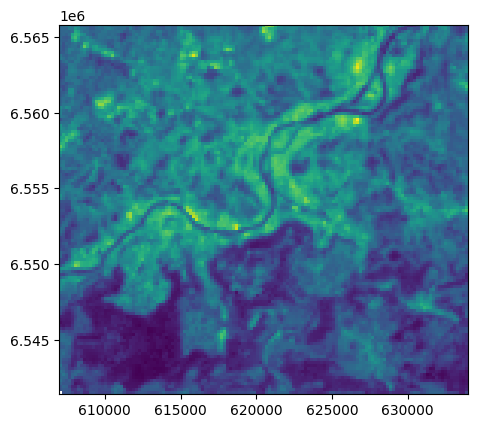

In [9]:
data = "../data/geotiff/liege_geotif.tif"
tiff = rasterio.open(data)
show(tiff)
list_city = ["liege","charleroi","mons","namur","tournai"]


## 2. Transformation du fichier en csv avec les centroids (lat/lon/valeur)

In [10]:
import rasterio
import numpy as np
from rasterio.features import shapes
import geopandas as gpd
for city in list_city: 
    # Load the GeoTiff
    with rasterio.open(f'../data/geotiff/{city}_geotif.tif') as src:
        # Convert the first band to float32
        image = src.read(1).astype(np.float32)
        # Extract shapes and values
        results = (
            {'properties': {'raster_value': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(image, transform=src.transform))
        )
    # Convert the results to a GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(results)
    # Explicitly set the CRS of the GeoDataFrame to the original CRS
    gdf.crs = "EPSG:3857"
    # Convert the GeoDataFrame to latitude/longitude
    gdf = gdf.to_crs("EPSG:4326")
    # Compute the centroids of the polygons
    centroids = gdf.geometry.centroid
    # Add the centroids as new columns in the GeoDataFrame
    gdf['centroid_lon'] = centroids.x
    gdf['centroid_lat'] = centroids.y
    # Select the columns to include in the CSV
    csv_data = gdf[['centroid_lon', 'centroid_lat', 'raster_value']]
    # Save the data to a CSV file
    csv_data.to_csv(f'../data/centroids/{city}_centroids.csv', index=False)

C:\Users\Décrypte\AppData\Local\Temp\ipykernel_8296\253007654.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid
C:\Users\Décrypte\AppData\Local\Temp\ipykernel_8296\253007654.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid
C:\Users\Décrypte\AppData\Local\Temp\ipykernel_8296\253007654.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid
C:\Users\Décrypte\AppData\Local\Temp\ipykernel_8296\253007654.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'c

## 3. Transformation en geojson (pas utilisé dans notre cas mais utiles)

In [4]:
import rasterio
import numpy as np
from rasterio.features import shapes
import geopandas as gpd
import json

# Load the GeoTiff
with rasterio.open('../assets/Charleroi_geotif.tif') as src:
    # Convert the first band to float32
    image = src.read(1).astype(np.float32)
    # Extract shapes and values
    results = (
        {'properties': {'raster_value': v}, 'geometry': s}
        for i, (s, v) in enumerate(shapes(image, transform=src.transform))
    )
# Convert the results to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(results)
# Convert the GeoDataFrame to GeoJSON
geojson = gdf.to_json()
# Save the GeoJSON to a file
with open("../assets/exemple.geojson", "w") as f:
    f.write(json.dumps(json.loads(geojson), indent=4))

(16467, 3)


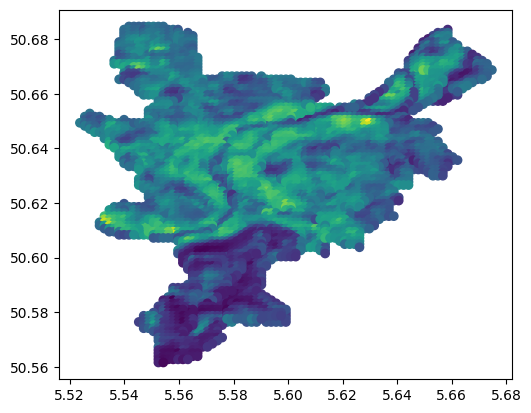

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load le fichier csv avec les centroid (donc latitude, longitude, température)
data = pd.read_csv('..\data\centroids\Liege_centroids.csv')
print(data.shape)
# un geojson de la région bruxelloise que j'avais en stock 
# (je l'ajoute en dessous du bloc de code dans Notion au cas où)
geo_data = gpd.read_file('..\data\secteurs\liege_secteur.geojson')
#print(geo_data.head())
#geo_data.plot(aspect=1)
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.centroid_lon, data.centroid_lat), crs="EPSG:4326")
#print(gdf.head())
#gdf.plot(aspect=1,column="raster_value")
# Perform the spatial join
merged = gpd.sjoin(gdf, geo_data, predicate='within')
merged.plot(aspect=1,column="raster_value")

# Extract the name_fr (municipality name) column from the joined data
geo_data['cd_sector'] = merged['']

merged.to_file(f"../data/revenu_densite_geojson/{city}_revenu_densite.geojson", driver="GeoJSON")

(16467, 3)
(4224, 10)
(26291, 3)
(6289, 10)
(23636, 3)
(8977, 10)
(41842, 3)
(10833, 10)
(28555, 3)
(13220, 10)


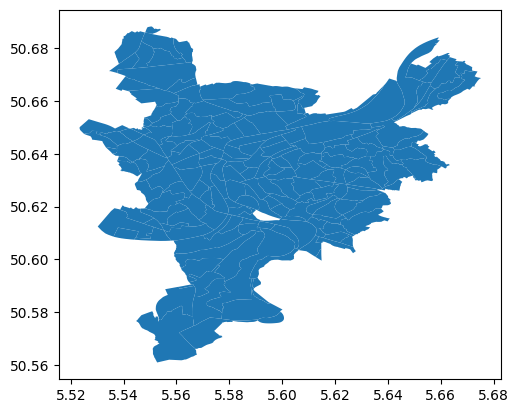

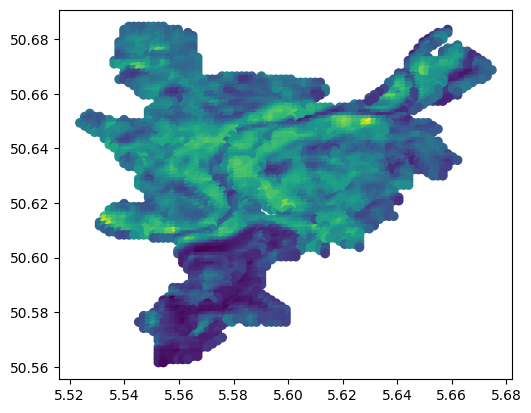

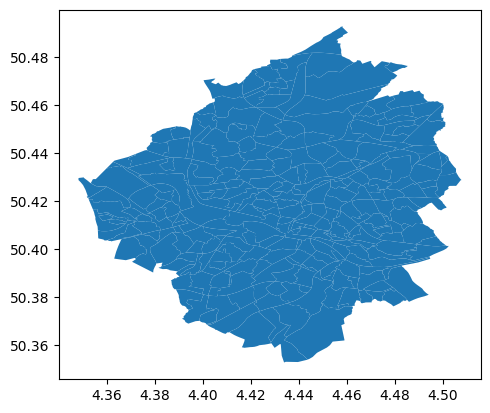

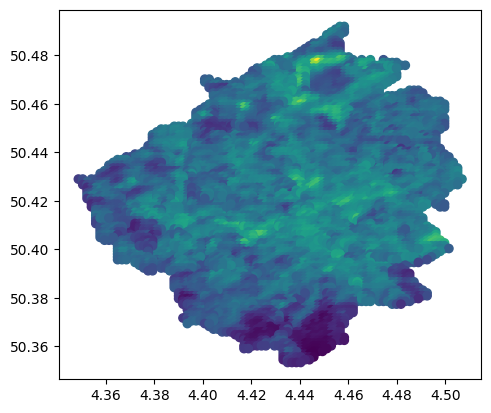

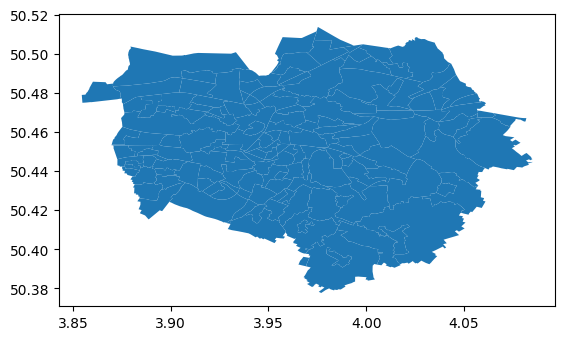

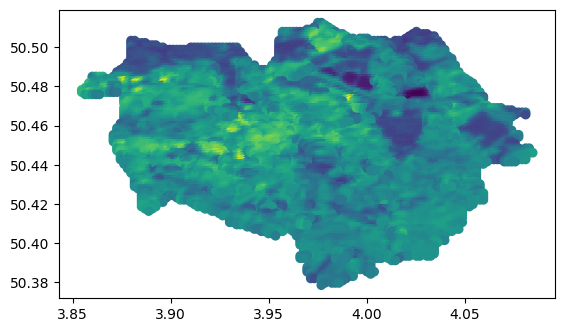

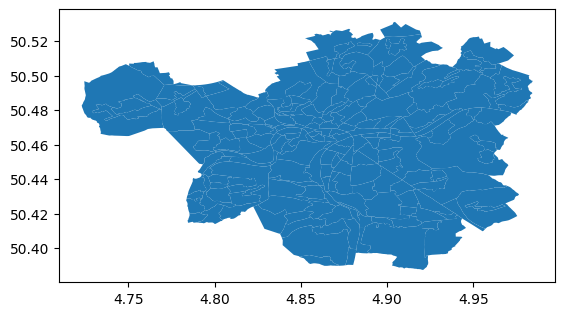

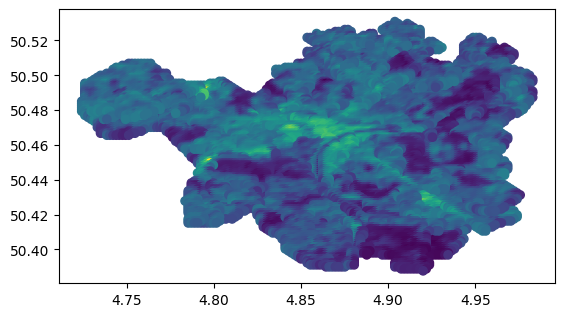

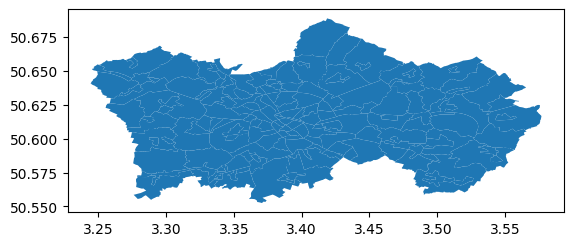

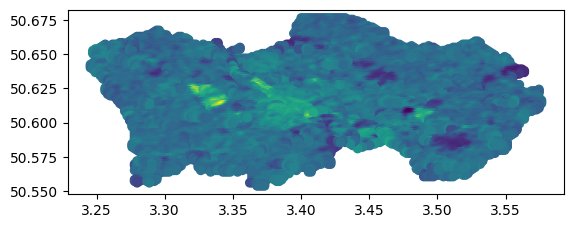

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
list_city = ["liege","charleroi","mons","namur","tournai"]

for city in list_city: 
    # Load le fichier csv avec les centroid (donc latitude, longitude, température)
    data = pd.read_csv(f'..\data\centroids\{city}_centroids.csv')
    print(data.shape)
    # un geojson de la région bruxelloise que j'avais en stock 
    # (je l'ajoute en dessous du bloc de code dans Notion au cas où)
    geo_data = gpd.read_file(f'../data/revenu_densite_geojson/{city}_revenu_densite.geojson')
    #print(geo_data.head())
    geo_data.plot(aspect=1)
    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.centroid_lon, data.centroid_lat), crs="EPSG:4326")
    #print(gdf.head())
    #gdf.plot(aspect=1,column="raster_value")
    # Perform the spatial join
    merged = gpd.sjoin(gdf, geo_data, predicate='within')
    merged.plot(aspect=1,column="raster_value")

    #Extract the name_fr (municipality name) column from the joined data
    geo_data['REVENU_MOYEN'] = merged['REVENU_MOYEN']
    geo_data['REVENU_MEDIAN'] = merged["REVENU_MEDIAN"]
    geo_data['NOMBRE_HAB'] = merged["NOMBRE_HAB"]
    geo_data['DENSITE_PAR_HECTARE'] = merged["DENSITE_PAR_HECTARE"]
    geo_data['ms_area_ha'] = merged["ms_area_ha"]

    final = merged[["centroid_lon","centroid_lat", "raster_value",
                    "tx_sector_descr_fr", "REVENU_MOYEN", "REVENU_MEDIAN",
                     "NOMBRE_HAB","geometry","DENSITE_PAR_HECTARE",
                     "ms_area_ha"]]
    print(final.shape)

    final.to_file(f"../assets/selection/{city}_sel_centroid.json", driver="GeoJSON")